# Data Science Agent in 10 Lines of Code
This notebook is a low-code, barebones example of how to create a Data Science Agent. 
It is a single function that takes a question and some data and executes code returned by an LLM. 
The following YouTube video is a walk-through of this notebook on YouTube.
# [📺 YouTube Tutorial 👇](https://www.youtube.com/watch?v=CCjxuVhKKok)
[![blah](https://img.youtube.com/vi/CCjxuVhKKok/0.jpg)](http://youtu.be/CCjxuVhKKok)

---  

# 📋 3 Requirements to Run Notebook
#### ✅ A local NVIDIA GPU or using a cloud hosted GPU service like [Google Colab](https://colab.research.google.com/)
#### ✅ Free NVIDA API Key from https://build.nvidia.com
#### ✅ Add NVIDA API Key as environment variable (shown below)

---  

# Notebook Outline
#### 🚀 NVIDIA cuDF
#### 💾 Data
#### 🔑 NVIDIA API Key
#### 💬 Prompt
#### 🤖 Agent Function
#### 📊 Agent in Action


---  

# Agent Overview
#### This notebook works by sending a question and data summary as a prompt to an LLM, asking for pandas code. 
#### Then the notebook executes the pandas code that opearates on the dataset, accelerated by [NVIDIA cuDF](https://developer.nvidia.com/topics/ai/data-science/cuda-x-data-science-libraries).
#### Flow of operations:
1. Prompt sent to LLM with:
    * Question / Data Query
    * Data Summary
    * Asking for pandas code
2. LLM response:
    * Executable pandas code

---  

# 🚀 [NVIDIA cuDF](https://developer.nvidia.com/topics/ai/data-science/cuda-x-data-science-libraries)
#### [This short blog](https://developer.nvidia.com/blog/rapids-cudf-accelerates-pandas-nearly-150x-with-zero-code-changes/) provides a little more detail.
#### cuDF is short for 
#### "cu" --> NVIDIA ***CU***DA-X
#### "DF" --> for ***D***ata ***F***rames
#### cudf will GPU accelerate 
 * [pandas](https://pandas.pydata.org/)
 * [Spark](https://docs.nvidia.com/spark-rapids/index.html)
 * [Polars](https://docs.pola.rs/user-guide/lazy/gpu/)

#### This ```%load_ext cudf.pandas``` command will create a GPU accelerated proxy type for pandas that accelerates pandas functions without having to change any existing code.   

In [1]:
# NVIDIA cuDF ( CUDA-X for Data Frames)
# GPU Acceleration for pandas, Spark, Polars
# https://rapids.ai/

%load_ext cudf.pandas

# 💾 Data
### Please try your own data but in this case we used a small data set from [Kaggle](https://kaggle.com)
### This data contains NYC Parking Violations and details about the cars getting the tickes.  
### It can can be found [here](https://www.kaggle.com/datasets/jiweiliu/nyc-parking-violations-2022-small)

In [3]:
# Data for Demo (any data should work though):
# https://www.kaggle.com/datasets/jiweiliu/nyc-parking-violations-2022-small
!unzip archive.zip

Archive:  archive.zip
  inflating: nyc_parking_violations_2022_small.parquet  


In [4]:
from openai import OpenAI
import pandas as pd

# 🔑 NVIDIA API Key 
### You will need a free NVIDIA API Key at https://build.nvidia.com
### That key will need to be available as an environment variable named `NVIDIA_API_KEY`
### If using Colab, [chapter 4](https://www.youtube.com/watch?v=CCjxuVhKKok&t=460s) in the YouTube mentioned above has detailed instructions.

In [5]:
# NVIDIA API KEY
# free at https://build.nvidia.com

# Google Colab Notebook
from google.colab import userdata
# NVIDIA_API_KEY = userdata.get('NVIDIA_API_KEY')

# ~ OR ~

# LOCAL
# os.getenv("NVIDIA_API_KEY")

# 💬 Prompt 
### This is an elaborate prompt designed to minimize ambiguity. The primary sections can be outlined as:
##### * Task
##### * Input
##### * Output
##### * Agent Behavior
##### * Examples

In [6]:
CONVO_CONTEXT = [{
    "role": "system",
    "content":
    '''
    **System Prompt:**
    You are an expert ML engineer and Data Scientist, specializing in advanced quantitave analysis and engaging, colorful plots using seabon pallettes.

    **Task:**
    Generate Python/pandas code to answer questions based on the supplied pandas DataFrame. Hide all warnings.

    **Input**
    `df`: a pandas DataFrame
    `user_question`: a string representation of a question to be answered

    **Output:**
    * A Python code snippet in a Markdown format that uses pandas to answer the `user_question` using the supplied pandas DataFrame in `df`
    * Do NOT include a line of code to create the pandas DataFrame.
    * Assign the final result in the form of a pandas DataFrame to a varible named `result_df`.
    * Assign any plot to a variable named `plot_obj` so that we can run `plot_obj.show()` in a Jupyter Notebook cell.
    * We will run the following code to get the `result_df` DataFrame and `plot_obj` from the code you return:

        env = {"pd": pd, "df": df}
        exec(code, {}, env)
        result_df = env.get("result_df", None)
        plot_obj = env.get("plot_obj", None)


    **Agent Behavior:**
    1. Analyze and perform reasoning on the `user_question`
    2. Write Python code using pandas to manipulate the supplied pandas DataFrame in `df` to answer the `user_question`
    3. Format the Python code in Markdown format.
    4. Output the generated Python code without any prefix or suffix. Only output Python code that can be executed directly.
    5. Add necessary explanation of code execution results using Python print() function at the end of the Python code.
    6. Your output should be clear and concise and only be a single solution.
    7. Include code to create colorful plots that help expain the answer with a preference for the built-in plots with pandas and seaborn.


    **Example Input:**
    ```python

    df="""
    "Product  Sales\n0      A    100\n1      B    200\n2      C    300"\n\n
    """
    user_question = "What are the total sales for each product?"
    ```

    **Expected Output:**

    ```python

    # Filter dataframe for product A
    product_a_sales = df[df['Product'] == 'A']

    # Calculate total sales for product A
    total_sales = product_a_sales['Sales'].sum()

    # Print explanation of the result
    print("Based on sales.csv, the total sales are:")

    # Print result
    print(total_sales)
    ```

    **Final instruction**: please just output one solution, code only!
    '''}]

# 🤖 Agent Function
### Parameters
##### 💬 query - the prompt sent to the LLM
##### 🌐 api_endpoint - the default here leverages NVIDIA's hosted LLM
##### 💾 df - data to be operated on
##### 🔑 api_key - NVIDIA API Key
##### 🤖 model - the default will work or choose different modesl at build.nvidia.com
### Overview
##### Using the parameters, the function will prompt the LLM, gather the code in the response, then execute the code. 
##### The pandas code will be GPU accelerated due to the ```{python}%load_ext cudf.pandas``` command executed in the first cell.

In [10]:
def agent(query: str,
          df=pd.read_parquet('nyc_parking_violations_2022_small.parquet'),
          api_endpoint='https://integrate.api.nvidia.com/v1',
          api_key=userdata.get('NVIDIA_API_KEY'),
          model='nvidia/llama-3.1-nemotron-ultra-253b-v1'
         ):


    # Declare Client to interact with remote AI
    # https://github.com/openai/openai-python
    client = OpenAI(base_url=api_endpoint, api_key=api_key)


    # Prompt
    user_prompt = f'''df = {df}  \n\n\n\n user_question = {query}'''
    messages = CONVO_CONTEXT + [{'role': 'user', 'content': user_prompt}]


    completion = client.chat.completions.create(model=model,
                                                messages=messages,
                                                temperature=0.5,
                                                top_p=1,
                                                max_tokens=1024,
                                                stream=False)


    # LLM Response
    llm_response = completion.choices[0].message.content
    # print(llm_response, end='\n\n\n\n#########\nEXECUTION:\n\n\n\n')


    # Extract & Run Python code
    exec((llm_response.split('```python')[1].split('```')[0].strip()),{'df':df})

In [11]:
# pd.read_parquet('nyc_parking_violations_2022_small.parquet')

# 📊 Agent in Action
##### Finally, this last cell is when the agent is used. 
##### The user sends their query or question in plain language form and gets a response based on the executed pandas code.

The age group with the most parking violations is: 6
Total violations for this age group: 9


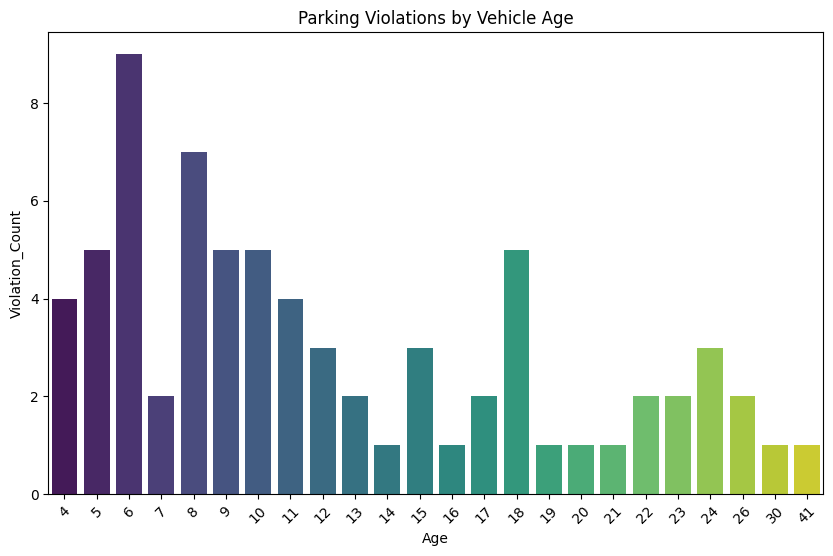

In [13]:
agent("""

Which age of vehicles gets the most parking violations?
The current year is 2025.
Remove outliers where the age is greater than 100.
Hide warnings.

""")